### Model devlopment
#### TCN (Temporal Convolution Neural Network)

In [1]:
import pandas as pd
import numpy as np
import darts
import yfinance as yf

# visualization
import matplotlib.pyplot as plt

# timeseries with darts
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.models import TCNModel

# RF model test with Covariate
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# darts model evaluation
from darts.metrics import mape, rmse, r2_score

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
# Data preparation for model development

df =pd.read_csv(r'C:\Users\dicod\Documents\2024\project_with Hamid(2024_3rd semester)\code\Data\final_df.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(lambda x:x[0:10])
df['Date'] = pd.to_datetime(df['Date'])


# dataframe to timeseries
ts_price = TimeSeries.from_dataframe(df, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')

# scaler
scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS] )

my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS], axis=1)

# split the data into train and validation
train, validation = my_multivariate_series.split_after(0.8)

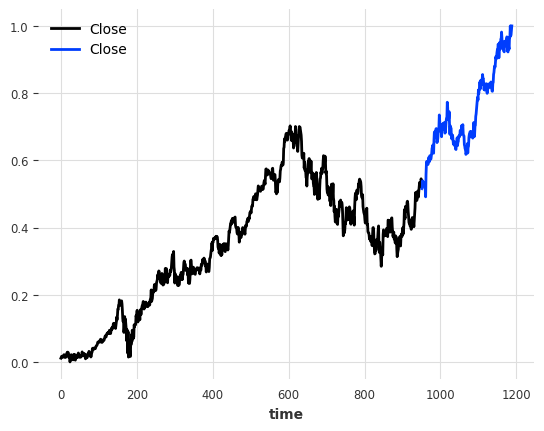

In [ ]:
train['Close'].plot()
validation['Close'].plot()

In [5]:
# define the covarients using train and validation data

past_cov_train_vol = train['Volume']
past_cov_val_vol = validation['Volume']

past_cov_train_fn = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val_fn = validation[['Volume', 'EPS', 'P/E', 'P/S']]

In [5]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.02,
    mode='min',
)
pl_trainer_kwargs={"callbacks": [my_stopper]}

### Hyper parameter define

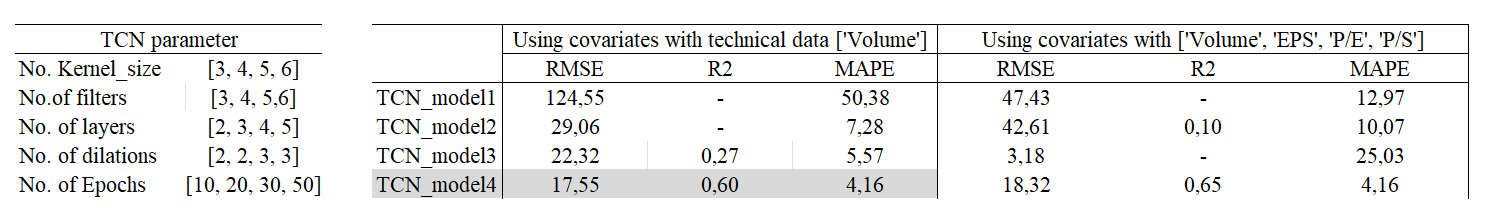

In [13]:
TCN_par1 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2,
    n_epochs=10
)
TCN_par1.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par1_rmse = rmse(pred_price,actual_price )
TCN_par1_r2 = r2_score(pred_price,actual_price )
TCN_par1_mape = mape(pred_price,actual_price )
print("RMSE = %.2f" % TCN_par1_rmse)
print("R2 = %.2f" % TCN_par1_r2)
print("MAPE = %.2f" % TCN_par1_mape)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 164   
----------------------------------------------------
164       Trainable params
0         Non-trainable params
164       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 124.55
R2 = -1667.83
MAPE = 50.38


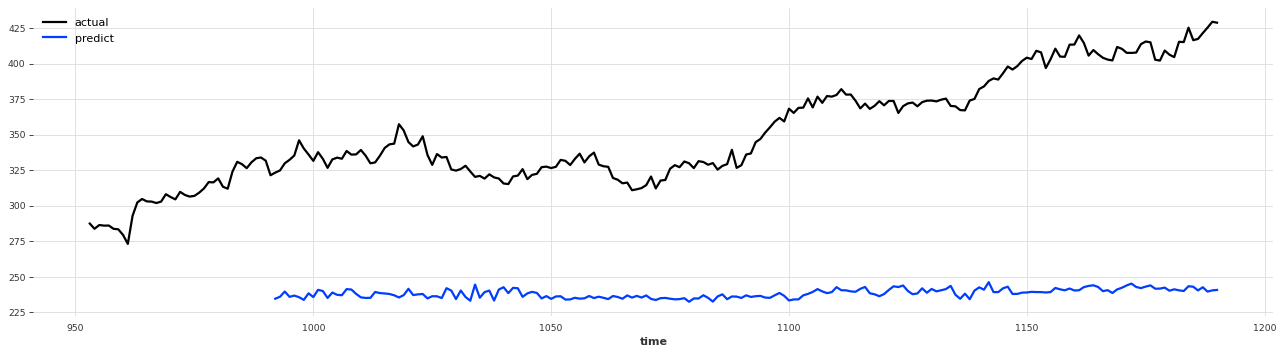

In [14]:
plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 342   
----------------------------------------------------
342       Trainable params
0         Non-trainable params
342       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 29.06
R2 = -0.87
MAPE = 7.28


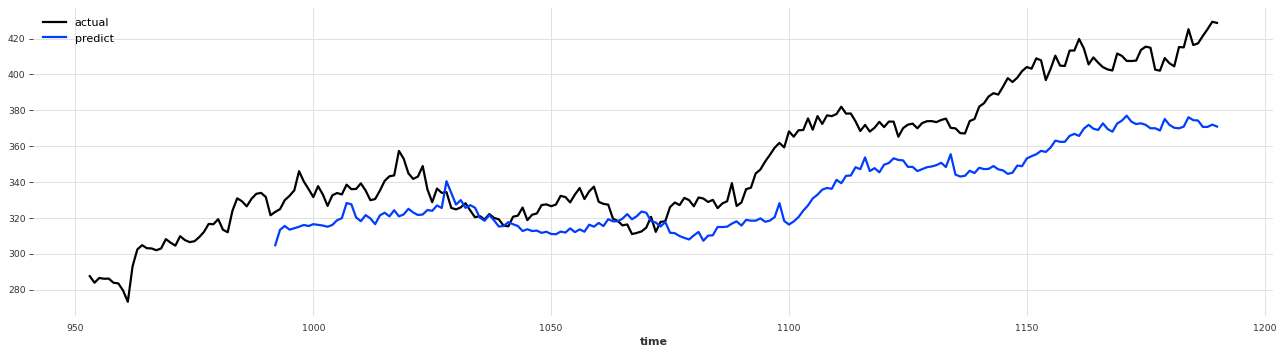

In [15]:
TCN_par2 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=3, dilation_base=2,
    n_epochs=20
)
TCN_par2.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par2_rmse = rmse(pred_price,actual_price)
TCN_par2_r2 = r2_score(pred_price,actual_price)
TCN_par2_mape = mape(pred_price,actual_price)
print("RMSE = %.2f" % TCN_par2_rmse)
print("R2 = %.2f" % TCN_par2_r2)
print("MAPE = %.2f" % TCN_par2_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 342   
----------------------------------------------------
342       Trainable params
0         Non-trainable params
342       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 27.52
R2 = -0.68
MAPE = 6.76


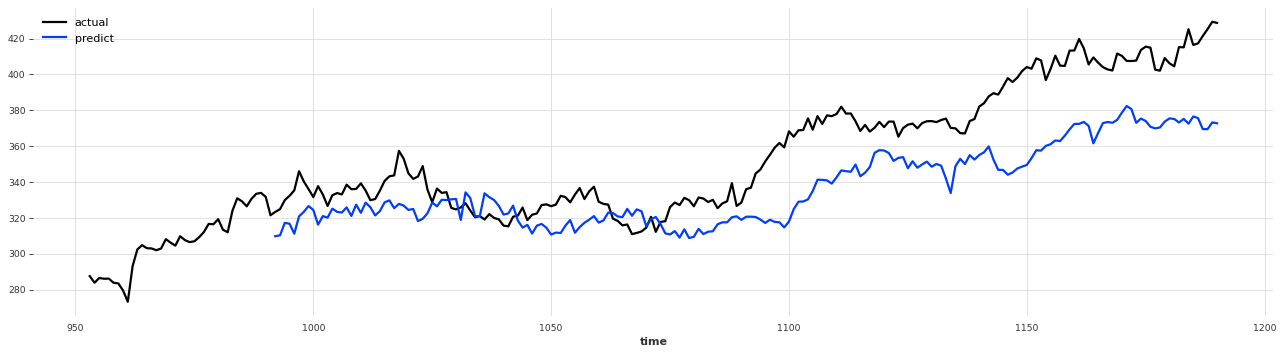

In [26]:
TCN_par2 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10, dropout=0.01,
    kernel_size=4, num_filters=4, num_layers=3, dilation_base=2,
    n_epochs=20
)
TCN_par2.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par2_rmse = rmse(pred_price,actual_price)
TCN_par2_r2 = r2_score(pred_price,actual_price)
TCN_par2_mape = mape(pred_price,actual_price)
print("RMSE = %.2f" % TCN_par2_rmse)
print("R2 = %.2f" % TCN_par2_r2)
print("MAPE = %.2f" % TCN_par2_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 882   
----------------------------------------------------
882       Trainable params
0         Non-trainable params
882       Total params
0.004     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 22.32
R2 = 0.27
MAPE = 5.57


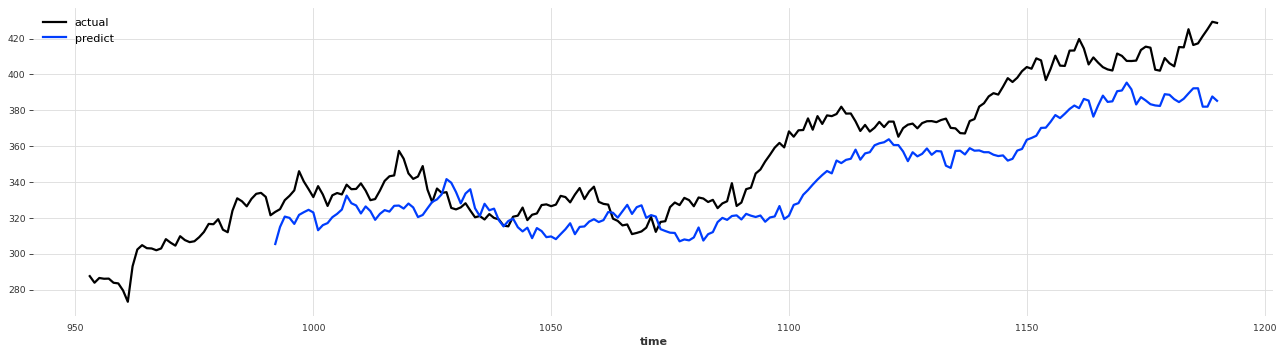

In [16]:
TCN_par3 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=5, num_filters=5, num_layers=4, dilation_base=3,
    n_epochs=30
)
TCN_par3.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par3_rmse = rmse(pred_price,actual_price)
TCN_par3_r2 = r2_score(pred_price,actual_price)
TCN_par3_mape = mape(pred_price,actual_price)
print("RMSE = %.2f" % TCN_par3_rmse)
print("R2 = %.2f" % TCN_par3_r2)
print("MAPE = %.2f" % TCN_par3_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.9 K 
----------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 17.55
R2 = 0.60
MAPE = 4.16


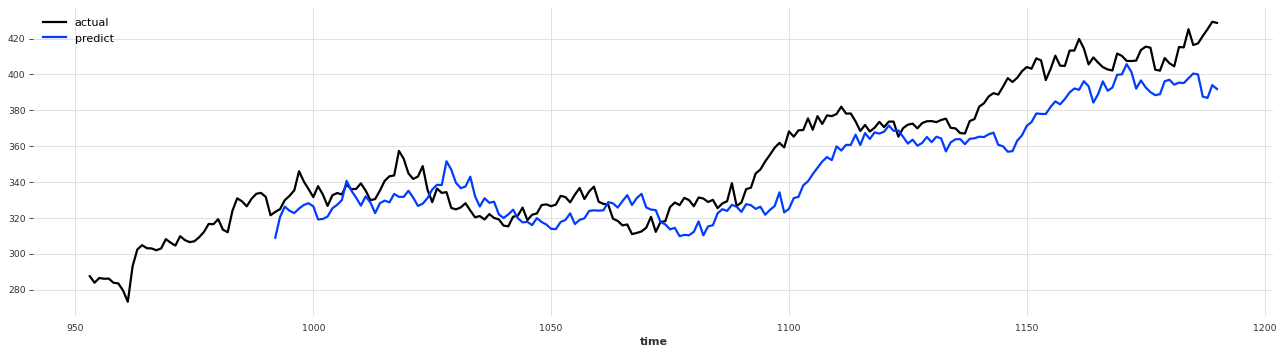

In [22]:
TCN_par4 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=6, num_filters=6, num_layers=5, dilation_base=3,
    n_epochs=50
)
TCN_par4.fit(train['Close'], past_covariates=past_cov_train_vol)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par4_rmse = rmse(pred_price,actual_price)
TCN_par4_r2 = r2_score(pred_price,actual_price)
TCN_par4_mape = mape(pred_price,actual_price)
print("RMSE = %.2f" % TCN_par4_rmse)
print("R2 = %.2f" % TCN_par4_r2)
print("MAPE = %.2f" % TCN_par4_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()

In [19]:
TCN_par1 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3, dilation_base=2,
    n_epochs=10
)
TCN_par1.fit(train['Close'], past_covariates=past_cov_train_fn)

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par1_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par1_rmse = rmse(pred_price,actual_price )
TCN_par1_r2 = r2_score(pred_price,actual_price )
TCN_par1_mape = mape(pred_price,actual_price )
print("RMSE = %.2f" % TCN_par1_rmse)
print("R2 = %.2f" % TCN_par1_r2)
print("MAPE = %.2f" % TCN_par1_mape)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 200   
----------------------------------------------------
200       Trainable params
0         Non-trainable params
200       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 47.43
R2 = -4.09
MAPE = 12.97


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 402   
----------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 42.61
R2 = 0.10
MAPE = 10.07


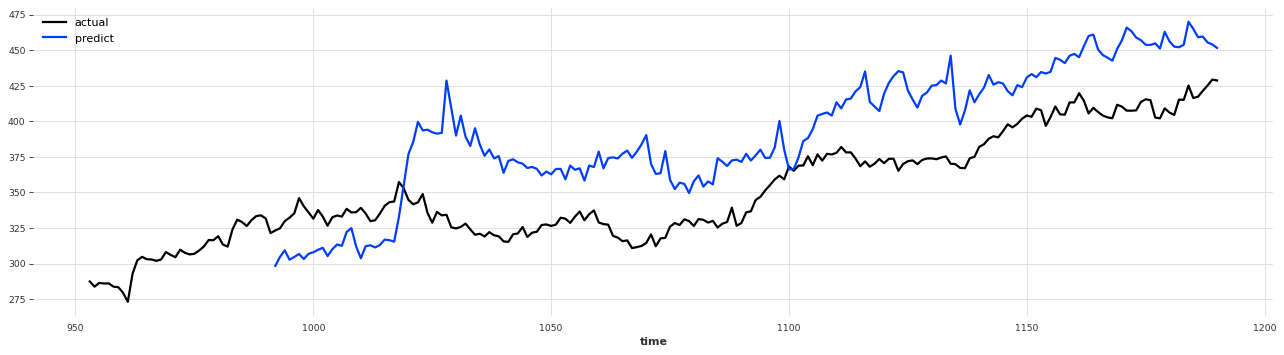

In [20]:
TCN_par2 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=3, dilation_base=2,
    n_epochs=20
)
TCN_par2.fit(train['Close'], past_covariates=past_cov_train_fn)

TCN_par2_pred_series = TCN_par2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par2_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par2_rmse = rmse(pred_price,actual_price)
TCN_par2_r2 = r2_score(pred_price,actual_price)
TCN_par2_mape = mape(pred_price,actual_price)
print("RMSE = %.2f" % TCN_par2_rmse)
print("R2 = %.2f" % TCN_par2_r2)
print("MAPE = %.2f" % TCN_par2_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 942   
----------------------------------------------------
942       Trainable params
0         Non-trainable params
942       Total params
0.004     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 76.17
R2 = -14.53
MAPE = 25.03


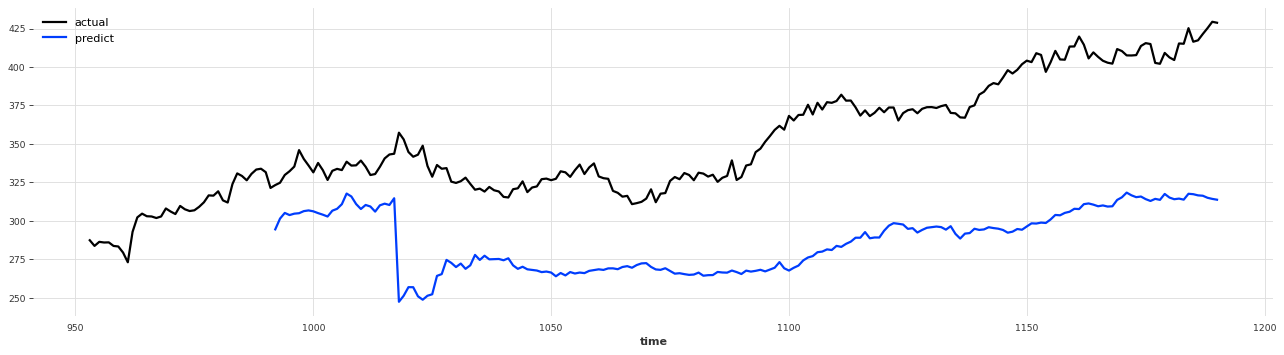

In [25]:
TCN_par3 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=5, num_filters=5, num_layers=4, dilation_base=2,
    n_epochs=30
)
TCN_par3.fit(train['Close'], past_covariates=past_cov_train_fn)

TCN_par3_pred_series = TCN_par3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par3_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par3_rmse = rmse(pred_price,actual_price)
TCN_par3_r2 = r2_score(pred_price,actual_price)
TCN_par3_mape = mape(pred_price,actual_price)
print("RMSE = %.2f" % TCN_par3_rmse)
print("R2 = %.2f" % TCN_par3_r2)
print("MAPE = %.2f" % TCN_par3_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 2.0 K 
----------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RMSE = 18.32
R2 = 0.65
MAPE = 4.16


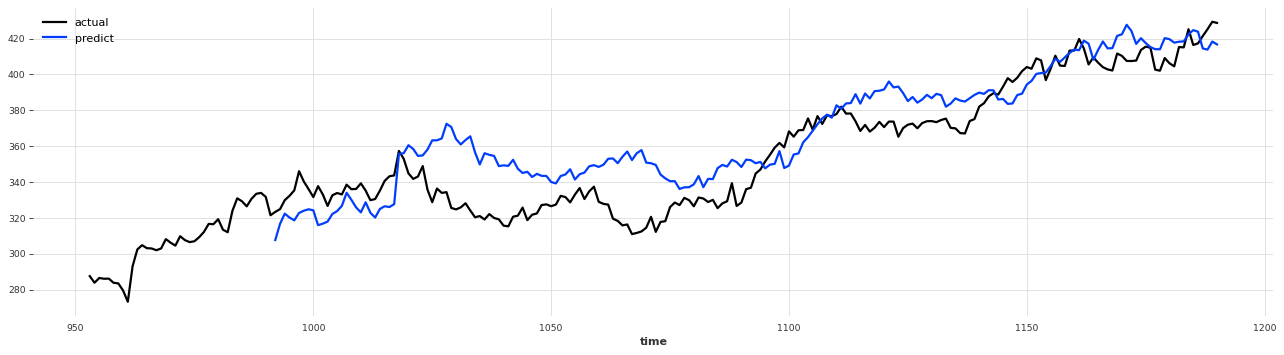

In [24]:
TCN_par4 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=6, num_filters=6, num_layers=5, dilation_base=2,
    n_epochs=50
)
TCN_par4.fit(train['Close'], past_covariates=past_cov_train_fn)

TCN_par4_pred_series = TCN_par4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False,
)
pred_price = scaler.inverse_transform(TCN_par4_pred_series)
actual_price = scaler.inverse_transform(validation['Close'])

TCN_par4_rmse = rmse(pred_price,actual_price)
TCN_par4_r2 = r2_score(pred_price,actual_price)
TCN_par4_mape = mape(pred_price,actual_price)
print("RMSE = %.2f" % TCN_par4_rmse)
print("R2 = %.2f" % TCN_par4_r2)
print("MAPE = %.2f" % TCN_par4_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_price.plot(label="actual")
pred_price.plot(label="predict")
plt.show()